# Figure showing emergence times of Arctic OLR with confidence intervals

Calculate emergence using the Weatherhead-Shaw approach. When letting the forced response evolve (time dependence), emergence differences between the Weatherhead and Leroy estimates of $\tau_{var}$ were minor. We use the Weatherhead method because it also works for short observational periods.

## Load Data

### Do imports

In [1]:
import sys

sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.

from imports import (
    np, xr, plt, sns, os, 
    glob,
    dask
    )

from functions import (
    to_png,
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Methods

#### Weatherhead et al. (1998)

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

Reformulation from Phojan et al. (2014):

$$ [\textrm{Var}(\hat{m})]^{1/2} \approx \left[ \frac{12}{T^3} \textrm{Var}(N_t) \tau_{W}  \right]^{1/2}, $$

where $N_t$ is the demeaned and detrended timeseries and $\tau_W$ is the Weatherhead correlation time given by

$$ \tau_W = \frac{1 + \phi}{1 - \phi}. $$

Time-to-emergence $\Delta t$. Emergence has occured if the length of the record exceeds the time-to-emergence.

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{W} \right]^{1/3}, $$

We will use the expression from Phojanamongkolkij (2014) because it is effectively the same as Leroy with a different expression for the correlation time. We take the lag-1 autocorrelation of the noise (taken from the PI-Control simulation), and the measured noise $\sigma_N$ (taken from the PI-Control simulation).

### Load pre-processed variability and trends

Pre-processing from timeseries to variability and trends is done in OLRemergence_temporal_preproc2.ipynb.

In [2]:
# Load variability

variability_day1_ds   = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_daily_20230417.nc')

variability_day5_ds   = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_day5_20230417.nc')

variability_day15_ds  = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_day15_20230417.nc')

variability_month1_ds = xr.open_dataset('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_20220109.nc')


In [3]:
# Load trends

trends_day1_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_day1.nc')

trends_day5_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_day5.nc')

trends_day15_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_day15.nc')

trends_month1_ds = xr.open_dataset('/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticMemberTrends/CESM1LEArcticTrends_month1.nc')

#### 3. Use the Weatherhead/Leroy/Phojanamongkolkij approach to calculate time-to-emergence for each ensemble member

Emergence occurs when the climate signal exits internal variability for the LAST time.

__More extensive code in fig6_OLRemergence_full.ipynb__ I do a comparison between Leroy and Weatherhead there.

In [5]:
emerge_vars = ['FLUT','TS','ICEFRAC','FSNTOA']

Calculate predicted time-to-emergence 

In [5]:
# TTE_W_all  = {}

# s = 2

# trend_data       = trends_day15_ds
# variability_data = variability_day15_ds

# # Using Weatherhead here. Best when the memory is small, which is true for all OLR fields
# # I need to iterate because the variability datasets are not indexed the same as
# # the trends, so they don't broadcast together perfectly.
# for _var in emerge_vars:
#     _stddevs   = variability_data.sel(variable=_var)['stddev']
#     _tauvars_W = variability_data.sel(variable=_var)['tauvar_Wea']
#     _slopes    = trend_data[_var]
    
#     # time calculated using a correlation time from the lag-1 method 
#     _TTE_W  = (12*s**2 * _stddevs**2 * _tauvars_W / _slopes**2)**(1/3)
#     _TTE_W.name = _var
#     _TTE_W = _TTE_W.drop('variable')
#     # _TTE_W  = (12*s**2 * _stddevs[_var]**2 * _tauvars_W[_var] / _slopes[_var]**2)**(1/3)
    
#     TTE_W_all[_var]  = _TTE_W

# TTE_W_day15 = xr.merge(TTE_W_all.values())

In [6]:
def calc_TTE_from_preproc(varlist,trend_data,variability_data,s=2):
    
    TTE_W_all  = {}
    
    for _var in varlist:
        _stddevs   = variability_data.sel(variable=_var)['stddev']
        _tauvars_W = variability_data.sel(variable=_var)['tauvar_Wea']
        _slopes    = trend_data[_var]

        # time calculated using a correlation time from the lag-1 method 
        _TTE_W  = (12*s**2 * _stddevs**2 * _tauvars_W / _slopes**2)**(1/3)
        _TTE_W.name = _var
        _TTE_W = _TTE_W.drop('variable')

        TTE_W_all[_var]  = _TTE_W

    return xr.merge(TTE_W_all.values())

In [7]:
TTE_W_day1   = calc_TTE_from_preproc(emerge_vars,trend_data=trends_day1_ds,variability_data=variability_day1_ds)

TTE_W_day5   = calc_TTE_from_preproc(emerge_vars,trend_data=trends_day5_ds,variability_data=variability_day5_ds)

TTE_W_day15  = calc_TTE_from_preproc(emerge_vars,trend_data=trends_day15_ds,variability_data=variability_day15_ds)

TTE_W_month1 = calc_TTE_from_preproc(emerge_vars,trend_data=trends_month1_ds,variability_data=variability_month1_ds)

__Translate to an emergence time (when the signal exits internal variability for the last time).__

In [8]:
def emergence_wrapper(TTE_data,dim='duration'):
    detect_ds = TTE_data < TTE_data.duration
    duration_broad = detect_ds.duration.broadcast_like(detect_ds)
    
    emergence_ds = 1 + duration_broad.where(~detect_ds).max(dim=dim)
    
    return emergence_ds

In [9]:
# Map the function across all variables.

emergence_W_day1   = TTE_W_day1.map(emergence_wrapper,dim='endyear')
emergence_W_day5   = TTE_W_day5.map(emergence_wrapper,dim='endyear')
emergence_W_day15  = TTE_W_day15.map(emergence_wrapper,dim='endyear')

emergence_W_month1 = TTE_W_month1.map(emergence_wrapper,dim='duration')

__Add asymmetry and use bootstrapping to limit the effect outliers.__

_Weatherhead estimates bootstrapped -->_

In [10]:
def bootstrap_CIs(data_ds,
                  nbootstraps=3000,
                  alpha=0.95,
                  axis=1,
                  coords_dict=dict(
                      # bound=[lower_bound,50,upper_bound], # bounds are percentiles now
                      month=np.arange(1,14,1),
                  )
                 ):
    
    N_ens = len(data_ds['ens']) # number of members
    gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array

    # Compute percentiles using bootstrapping
    lower_percentile = []
    upper_percentile = []
    mean_emergence = []

    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 1)
        resample_emergence = gen.choice(data_ds, size=N_ens, replace=True,axis=axis)
        # compute percentiles along the ensemble dimension (axis 1)
        lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=axis))
        upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=axis))
        mean_emergence.append(np.mean(resample_emergence,axis=axis))

    _lower_emerge_bstrap = np.mean(lower_percentile,axis=0) # take the mean percentile along the correct axis
    _upper_emerge_bstrap = np.mean(upper_percentile,axis=0)
    _mean_emerge_bstrap  = np.mean(mean_emergence,axis=0)

    time_coord = list(coords_dict.keys())[0]
    coords_dict['bound'] = [lower_bound,50,upper_bound]

    _emergence_LP_da = xr.DataArray(
        data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
        dims=["bound",time_coord],
        coords=coords_dict,
        # name = _var
    )
    
    return _emergence_LP_da

In [11]:
%time

# Bootstrap 95% confidence intervals

# These dictionaries tell the function how to organize the output after bootstrapping.
day1_coords_dict = dict(dayofyear=emergence_W_day1['dayofyear'],
                       )

day5_coords_dict = dict(dayofyear=emergence_W_day5['dayofyear'],
                       )

day15_coords_dict = dict(dayofyear=emergence_W_day15['dayofyear'],
                        )

# What day of the year is the 15th day of each month? Last (366) is for annual avg.
dayofyear_middlemonth = [15,46,74,105,135,166,196,227,258,288,319,349,366] 
month1_coords_dict = dict(dayofyear=dayofyear_middlemonth, 
                         )

emergence_W_CI_day1   = emergence_W_day1.map(bootstrap_CIs,coords_dict=day1_coords_dict)

emergence_W_CI_day5   = emergence_W_day5.map(bootstrap_CIs,coords_dict=day5_coords_dict)

emergence_W_CI_day15  = emergence_W_day15.map(bootstrap_CIs,coords_dict=day15_coords_dict)

emergence_W_CI_month1 = emergence_W_month1.map(bootstrap_CIs,coords_dict=month1_coords_dict)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.53 µs


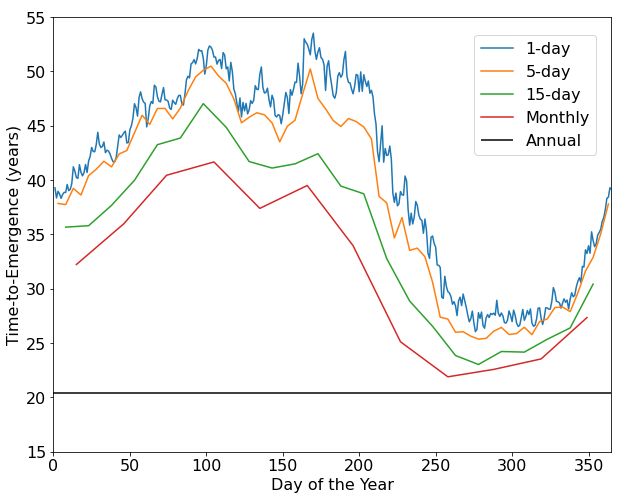

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

plt.plot(emergence_W_CI_day1['dayofyear'],emergence_W_CI_day1['FLUT'].sel(bound=50),
         label='1-day',
        )

plt.plot(emergence_W_CI_day5['dayofyear'],emergence_W_CI_day5['FLUT'].sel(bound=50),
         label='5-day',
        )

plt.plot(emergence_W_CI_day15['dayofyear'],emergence_W_CI_day15['FLUT'].sel(bound=50),
         label='15-day',
        )

plt.plot(emergence_W_CI_month1['dayofyear'][:12],emergence_W_CI_month1['FLUT'].sel(bound=50)[:12],
         label='Monthly',
        )


plt.hlines(y=emergence_W_CI_month1['FLUT'].sel(bound=50)[-1],xmin=0,xmax=365,
          color='black',
          label='Annual'
          )

ax.set_xlim(0,365)
ax.set_ylim(15,55)

ax.set_xlabel('Day of the Year',fontsize=16)
ax.set_ylabel('Time-to-Emergence (years)',fontsize=16)

ax.tick_params(axis='both',labelsize=16)

fig.legend(loc=(0.75,0.69),fontsize=16)


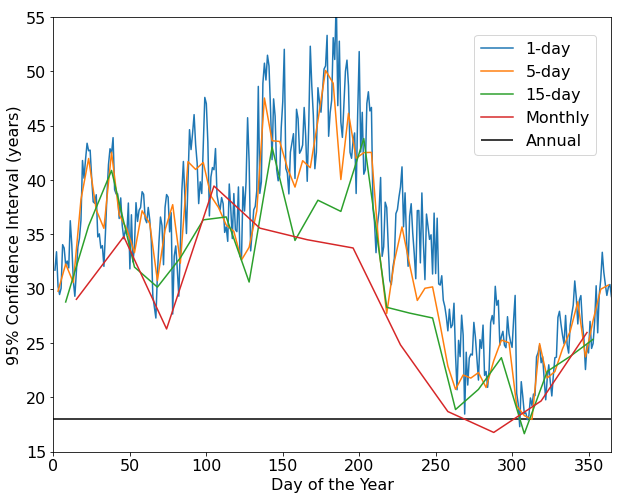

In [14]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

# Calculate the width of the CIs
day1_FLUT_CI   = emergence_W_CI_day1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day1['FLUT'].sel(bound=2.5,method='nearest')
day5_FLUT_CI   = emergence_W_CI_day5['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day5['FLUT'].sel(bound=2.5,method='nearest')
day15_FLUT_CI  = emergence_W_CI_day15['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day15['FLUT'].sel(bound=2.5,method='nearest')
month1_FLUT_CI = emergence_W_CI_month1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_month1['FLUT'].sel(bound=2.5,method='nearest')
year1_FLUT_CI  = month1_FLUT_CI[-1]

plt.plot(emergence_W_CI_day1['dayofyear'],day1_FLUT_CI,
         label='1-day',
        )

plt.plot(emergence_W_CI_day5['dayofyear'],day5_FLUT_CI,
         label='5-day',
        )

plt.plot(emergence_W_CI_day15['dayofyear'],day15_FLUT_CI,
         label='15-day',
        )

plt.plot(emergence_W_CI_month1['dayofyear'][:12],month1_FLUT_CI[:12],
         label='Monthly',
        )

plt.hlines(y=year1_FLUT_CI,xmin=0,xmax=365,
          color='black',
          label='Annual'
          )

ax.set_xlim(0,365)
ax.set_ylim(15,55)

ax.set_xlabel('Day of the Year',fontsize=16)
ax.set_ylabel('95% Confidence Interval (years)',fontsize=16)

ax.tick_params(axis='both',labelsize=16)

fig.legend(loc=(0.75,0.69),fontsize=16)


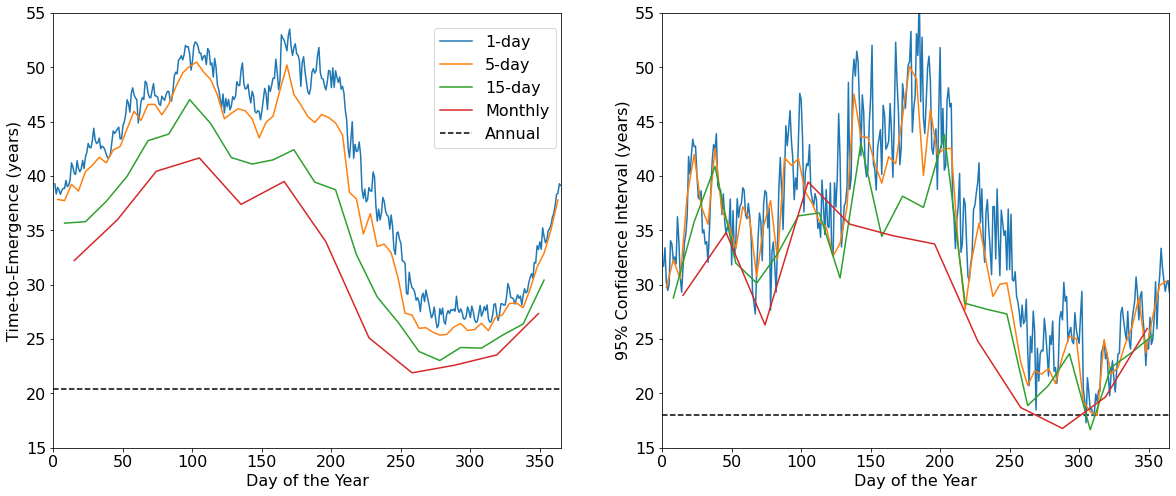

In [85]:
fig,ax = plt.subplots(1,2,figsize=(20,8))

# Calculate the width of the CIs
day1_FLUT_CI   = emergence_W_CI_day1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day1['FLUT'].sel(bound=2.5,method='nearest')
day5_FLUT_CI   = emergence_W_CI_day5['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day5['FLUT'].sel(bound=2.5,method='nearest')
day15_FLUT_CI  = emergence_W_CI_day15['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day15['FLUT'].sel(bound=2.5,method='nearest')
month1_FLUT_CI = emergence_W_CI_month1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_month1['FLUT'].sel(bound=2.5,method='nearest')
year1_FLUT_CI  = month1_FLUT_CI[-1]

# Plot the Mean TTE
ax[0].plot(emergence_W_CI_day1['dayofyear'],emergence_W_CI_day1['FLUT'].sel(bound=50),
           label='1-day',
          )

ax[0].plot(emergence_W_CI_day5['dayofyear'],emergence_W_CI_day5['FLUT'].sel(bound=50),
           label='5-day',
          )

ax[0].plot(emergence_W_CI_day15['dayofyear'],emergence_W_CI_day15['FLUT'].sel(bound=50),
           label='15-day',
          )

ax[0].plot(emergence_W_CI_month1['dayofyear'][:12],emergence_W_CI_month1['FLUT'].sel(bound=50)[:12],
           label='Monthly',
          )


ax[0].hlines(y=emergence_W_CI_month1['FLUT'].sel(bound=50)[-1],xmin=0,xmax=365,
            color='black',
            label='Annual',
            linestyle='dashed',
            )

# Plot the width of the CIs
ax[1].plot(emergence_W_CI_day1['dayofyear'],day1_FLUT_CI,
           label='1-day',
          )

ax[1].plot(emergence_W_CI_day5['dayofyear'],day5_FLUT_CI,
           label='5-day',
          )

ax[1].plot(emergence_W_CI_day15['dayofyear'],day15_FLUT_CI,
           label='15-day',
          )

ax[1].plot(emergence_W_CI_month1['dayofyear'][:12],month1_FLUT_CI[:12],
           label='Monthly',
          )

ax[1].hlines(y=year1_FLUT_CI,xmin=0,xmax=365,
             color='black',
             label='Annual',
             linestyle='dashed',
            )

ax[0].set_xlim(0,365)
ax[0].set_ylim(15,55)

ax[0].set_xlabel('Day of the Year',fontsize=16)
ax[0].set_ylabel('Time-to-Emergence (years)',fontsize=16)

ax[1].set_xlim(0,365)
ax[1].set_ylim(15,55)

ax[1].set_xlabel('Day of the Year',fontsize=16)
ax[1].set_ylabel('95% Confidence Interval (years)',fontsize=16)

ax[0].tick_params(axis='both',labelsize=16)
ax[1].tick_params(axis='both',labelsize=16)

ax[0].legend(loc=(0.75,0.69),fontsize=16)


In [16]:
# to_png(fig,filename='OLR_emergence_temporalscales',dpi=300,ext='pdf',bbox_inches='tight')

- When there is less variability, you reach the averaging floor more quickly. We can see that the monthly averages are always lower than the 15-day averages, but in September they start to get close together.

- Averaging reduces the average TTE. But the 95% confidence interval is pretty constant. I'd expect a much larger 95% confidence interval with the higher frequency data, but I guess that's not the case.

In [41]:
mean_trend_day1   = trends_day1_ds.sel(endyear=2021).mean(dim='ens') #['FLUT']
mean_trend_day5   = trends_day5_ds.sel(endyear=2021).mean(dim='ens') #['FLUT']
mean_trend_day15  = trends_day15_ds.sel(endyear=2021).mean(dim='ens') #['FLUT']
mean_trend_month1 = trends_month1_ds.sel(duration=21).mean(dim='ens') #['FLUT']

mean_trend_month1['dayofyear'] = dayofyear_middlemonth

In [82]:
total_unc_day1   = (variability_day1_ds['stddev'] * variability_day1_ds['tauvar_Wea']**(1/2)) #.sel(variable='FLUT')
total_unc_day5   = (variability_day5_ds['stddev'] * variability_day5_ds['tauvar_Wea']**(1/2)) #sel(variable='FLUT')
total_unc_day15  = (variability_day15_ds['stddev'] * variability_day15_ds['tauvar_Wea']**(1/2)) #.sel(variable='FLUT')
total_unc_month1 = (variability_month1_ds['stddev'] * variability_month1_ds['tauvar_Wea']**(1/2)) #.sel(variable='FLUT')

# total_unc_month1.assign_coords({"dayofyear": dayofyear_middlemonth})
# total_unc_month1.expand_dims('dayofyear',dayofyear_middlemonth)

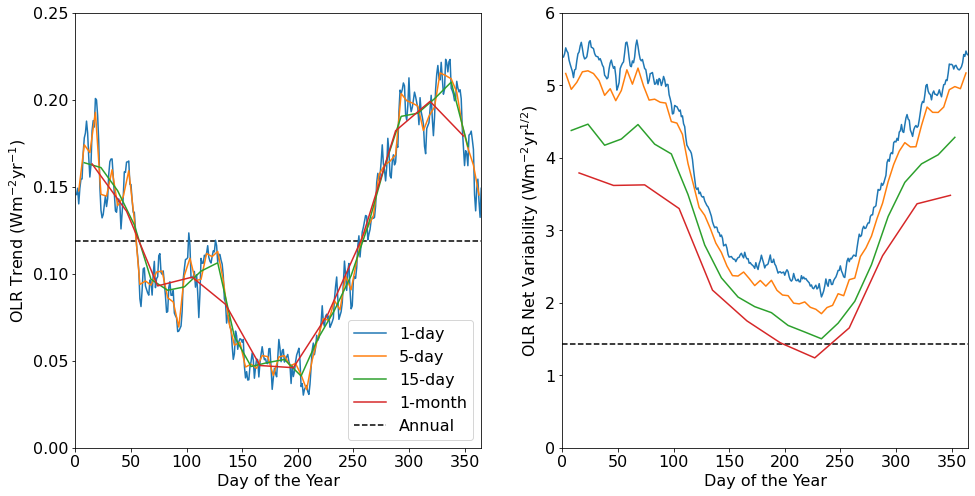

In [83]:
fig,axs = plt.subplots(1,2,figsize=(16,8))

plt_var = 'FLUT'

axs[0].plot(mean_trend_day1.dayofyear,mean_trend_day1[plt_var],label='1-day')
axs[0].plot(mean_trend_day5.dayofyear,mean_trend_day5[plt_var],label='5-day')
axs[0].plot(mean_trend_day15.dayofyear,mean_trend_day15[plt_var],label='15-day')
axs[0].plot(mean_trend_month1.dayofyear[:-1],mean_trend_month1[plt_var][:-1],label='1-month')
    
axs[0].hlines(y=mean_trend_month1[plt_var][-1],xmin=0,xmax=365,
              color='black',
              label='Annual',
              linestyle='dashed',
              zorder=0
              )

axs[1].plot(total_unc_day1.dayofyear,total_unc_day1.sel(variable=plt_var),label='1-day')
axs[1].plot(total_unc_day5.dayofyear,total_unc_day5.sel(variable=plt_var),label='5-day')
axs[1].plot(total_unc_day15.dayofyear,total_unc_day15.sel(variable=plt_var),label='15-day')
axs[1].plot(dayofyear_middlemonth[:-1],total_unc_month1.sel(variable=plt_var)[:-1],label='1-month')

axs[1].hlines(y=total_unc_month1.sel(variable=plt_var)[-1],xmin=0,xmax=365,
              color='black',
              label='Annual',
              linestyle='dashed',
              zorder=0
             )

axs[0].tick_params(axis='both',labelsize=16)
axs[1].tick_params(axis='both',labelsize=16)

axs[0].set_xlim(0,365)
axs[0].set_ylim(0,0.25)

axs[1].set_xlim(0,365)
axs[1].set_ylim(0,6)

axs[0].set_xlabel('Day of the Year',fontsize=16)
axs[0].set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=16)

axs[1].set_xlabel('Day of the Year',fontsize=16)
axs[1].set_ylabel('OLR Net Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=16)


axs[0].legend(fontsize=16,loc='lower right')

# plt.plot(total_unc_day1.dayofyear,total_unc_day1)

Text(0.556, 0.45, 'd.')

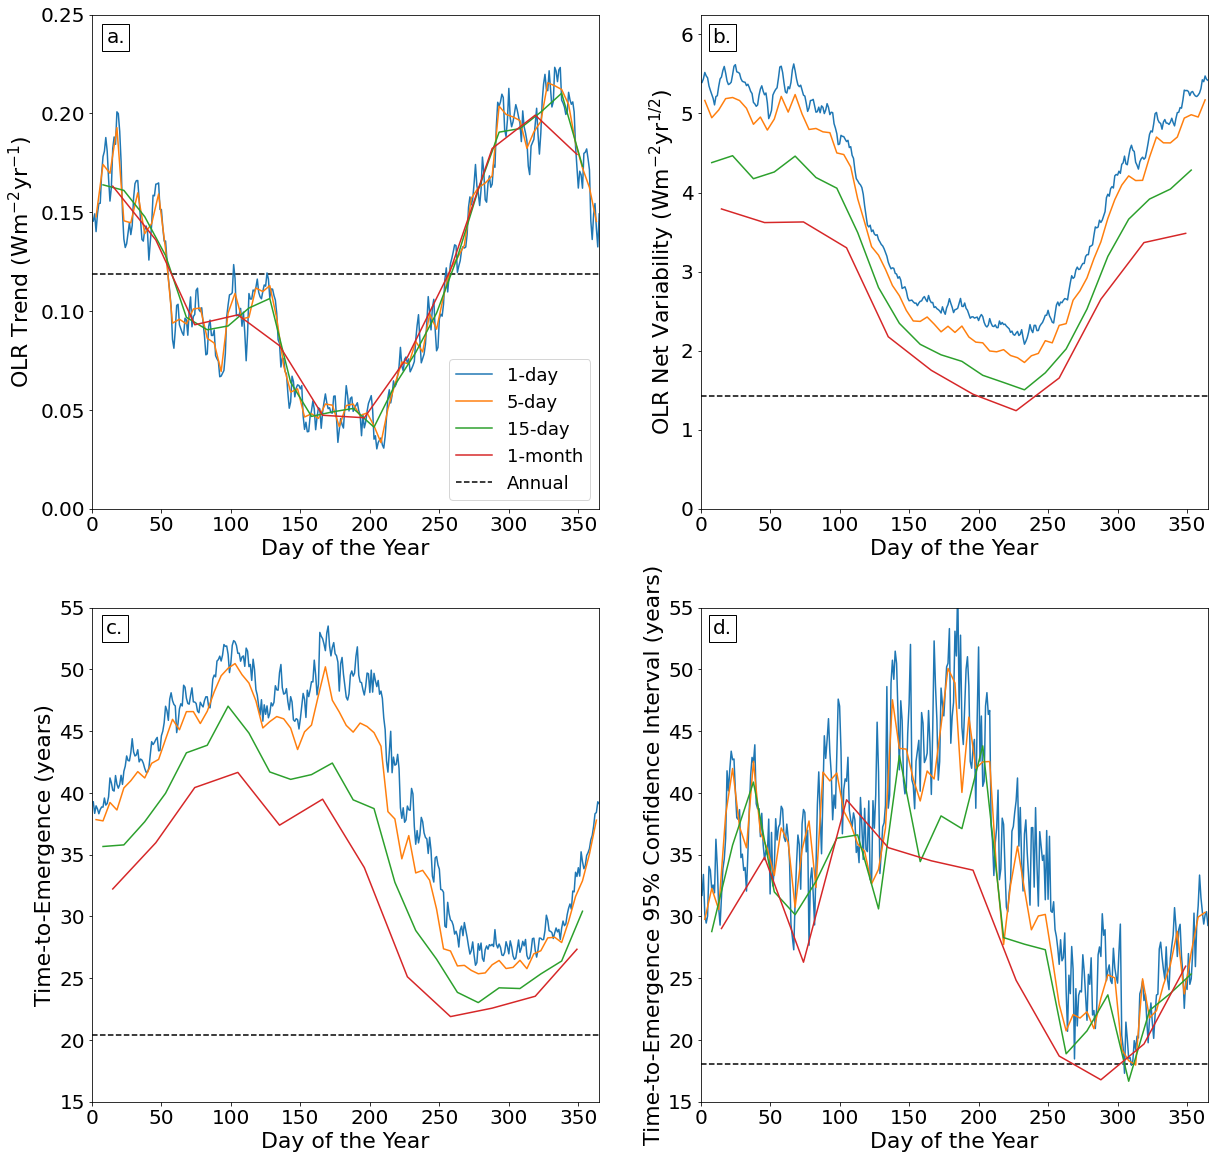

In [117]:
fig,axs = plt.subplots(2,2,figsize=(20,20))
axs = axs.flat

plt_var = 'FLUT'
props = dict(facecolor='white', alpha=1)

# Calculate the width of the CIs
day1_FLUT_CI   = emergence_W_CI_day1[plt_var].sel(bound=97.5,method='nearest') - emergence_W_CI_day1[plt_var].sel(bound=2.5,method='nearest')
day5_FLUT_CI   = emergence_W_CI_day5[plt_var].sel(bound=97.5,method='nearest') - emergence_W_CI_day5[plt_var].sel(bound=2.5,method='nearest')
day15_FLUT_CI  = emergence_W_CI_day15[plt_var].sel(bound=97.5,method='nearest') - emergence_W_CI_day15[plt_var].sel(bound=2.5,method='nearest')
month1_FLUT_CI = emergence_W_CI_month1[plt_var].sel(bound=97.5,method='nearest') - emergence_W_CI_month1[plt_var].sel(bound=2.5,method='nearest')
year1_FLUT_CI  = month1_FLUT_CI[-1]

# Plot the 21-year trends
axs[0].plot(mean_trend_day1.dayofyear,mean_trend_day1[plt_var],label='1-day')
axs[0].plot(mean_trend_day5.dayofyear,mean_trend_day5[plt_var],label='5-day')
axs[0].plot(mean_trend_day15.dayofyear,mean_trend_day15[plt_var],label='15-day')
axs[0].plot(mean_trend_month1.dayofyear[:-1],mean_trend_month1[plt_var][:-1],label='1-month')
    
axs[0].hlines(y=mean_trend_month1[plt_var][-1],xmin=0,xmax=365,
              color='black',
              label='Annual',
              linestyle='dashed',
              zorder=0
              )

# Plot the net variability
axs[1].plot(total_unc_day1.dayofyear,total_unc_day1.sel(variable=plt_var),label='1-day')
axs[1].plot(total_unc_day5.dayofyear,total_unc_day5.sel(variable=plt_var),label='5-day')
axs[1].plot(total_unc_day15.dayofyear,total_unc_day15.sel(variable=plt_var),label='15-day')
axs[1].plot(dayofyear_middlemonth[:-1],total_unc_month1.sel(variable=plt_var)[:-1],label='1-month')

axs[1].hlines(y=total_unc_month1.sel(variable=plt_var)[-1],xmin=0,xmax=365,
              color='black',
              label='Annual',
              linestyle='dashed',
              zorder=0
             )

axs[0].tick_params(axis='both',labelsize=20)
axs[1].tick_params(axis='both',labelsize=20)

axs[0].set_xlim(0,365)
axs[0].set_ylim(0,0.25)

axs[1].set_xlim(0,365)
axs[1].set_ylim(0,6.25)

axs[0].set_xlabel('Day of the Year',fontsize=22)
axs[0].set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=22)

axs[1].set_xlabel('Day of the Year',fontsize=22)
axs[1].set_ylabel('OLR Net Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=22)


axs[0].legend(fontsize=18,loc='lower right')

# Plot the Mean TTE
axs[2].plot(emergence_W_CI_day1['dayofyear'],emergence_W_CI_day1[plt_var].sel(bound=50),
           label='1-day',
          )

axs[2].plot(emergence_W_CI_day5['dayofyear'],emergence_W_CI_day5[plt_var].sel(bound=50),
           label='5-day',
          )

axs[2].plot(emergence_W_CI_day15['dayofyear'],emergence_W_CI_day15[plt_var].sel(bound=50),
           label='15-day',
          )

axs[2].plot(emergence_W_CI_month1['dayofyear'][:12],emergence_W_CI_month1[plt_var].sel(bound=50)[:12],
           label='Monthly',
          )


axs[2].hlines(y=emergence_W_CI_month1[plt_var].sel(bound=50)[-1],xmin=0,xmax=365,
            color='black',
            label='Annual',
            linestyle='dashed',
            )

# Plot the width of the CIs
axs[3].plot(emergence_W_CI_day1['dayofyear'],day1_FLUT_CI,
           label='1-day',
          )

axs[3].plot(emergence_W_CI_day5['dayofyear'],day5_FLUT_CI,
           label='5-day',
          )

axs[3].plot(emergence_W_CI_day15['dayofyear'],day15_FLUT_CI,
           label='15-day',
          )

axs[3].plot(emergence_W_CI_month1['dayofyear'][:12],month1_FLUT_CI[:12],
           label='Monthly',
          )

axs[3].hlines(y=year1_FLUT_CI,xmin=0,xmax=365,
             color='black',
             label='Annual',
             linestyle='dashed',
            )

axs[2].set_xlim(0,365)
axs[2].set_ylim(15,55)

axs[2].set_xlabel('Day of the Year',fontsize=22)
axs[2].set_ylabel('Time-to-Emergence (years)',fontsize=22)

axs[3].set_xlim(0,365)
axs[3].set_ylim(15,55)

axs[3].set_xlabel('Day of the Year',fontsize=22)
axs[3].set_ylabel('Time-to-Emergence 95% Confidence Interval (years)',fontsize=22)

axs[2].tick_params(axis='both',labelsize=20)
axs[3].tick_params(axis='both',labelsize=20)

fig.text(0.135,0.86,'a.',fontdict={'fontsize':20,'rotation':0},bbox=props)
fig.text(0.556,0.86,'b.',fontdict={'fontsize':20,'rotation':0},bbox=props)
fig.text(0.135,0.45,'c.',fontdict={'fontsize':20,'rotation':0},bbox=props)
fig.text(0.556,0.45,'d.',fontdict={'fontsize':20,'rotation':0},bbox=props)


In [119]:
# to_png(fig,filename='OLR_emergence_temporalscales_4panel',dpi=300,ext='pdf',bbox_inches='tight')